# Shopping Cart analysis (Random Forest)
## "What factors decide which products to be purchased while others stay in the shopping cart forever?"

##### - about the data
The data set used in below analysis is a part of shopping cart data sets of one fashion e-commerce platform. 

*data: 'shopping_cart.csv' 
- It contains the part of shopping carts data of three high-end fashion brands.
- It has collected during 01/01/2022 ~ 07/31/2022

##### - about the columns
Description is centered on the columns that are mainly dealt with in the analysis.

- Cart_date: the date that a customer added a product
- Brand_no: three brands that are dealt with in this analysis - for convenience, I named them brand_1, 2, 3
- Product_no: the unique number of the products
- Purchase_date: the date that a customer bought a product, the column also contains 'not purchase'
- Funnel: the sales/marketing funnels that customers went through right before adding products to cart.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data = pd.read_csv('shopping_cart.csv')

In [3]:
data.head()

,Shopping_cart_no,Membership_no,Cart_date,Brand_no,Product_sku_no,Product_no,Purchase_date,Order_no,Cart_amount,Purchase_amount,Order_payment_amount,Final_payment_amount,Funnel,Item,Full_Price (10k / KRW),Discount_percent,Discounted_Price,Coupon_Y/N
0,220100049313001,1.000001e+09,20220116,58,5811327538000TU,5811327538,20220116,202201165811267,1,Refund,Refund,Refund,category,BAG,133,0.30,93,N
1,220700058680669,2.020080e+14,20220726,58,5811327538000TU,5811327538,20220726,202207267414661,1,1,"850,000","850,000",NaN,BAG,133,0.36,85,N
2,220400053262376,2.020070e+14,20220407,58,5812127535000TU,5812127535,20220407,202204076448145,1,Refund,Refund,Refund,event,BAG,137,0.46,74,N
3,220700058706216,2.021123e+14,20220726,58,5811327538000TU,5811327538,20220726,202207267421129,1,Refund,Refund,Refund,NaN,BAG,133,0.53,63,N
4,220700058714676,2.022073e+14,20220726,58,5811327538000TU,5811327538,20220726,202207267422346,1,1,"850,000","850,000",NaN,BAG,133,0.95,85,N


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75770 entries, 0 to 75769
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Shopping_cart_no        75770 non-null  int64  
 1   Membership_no           75768 non-null  float64
 2   Cart_date               75770 non-null  int64  
 3   Brand_no                75770 non-null  int64  
 4   Product_sku_no          75770 non-null  object 
 5   Product_no              75770 non-null  object 
 6   Purchase_date           75770 non-null  object 
 7   Order_no                75770 non-null  object 
 8   Cart_amount             75770 non-null  int64  
 9   Purchase_amount         75770 non-null  object 
 10  Order_payment_amount    75770 non-null  object 
 11  Final_payment_amount    75770 non-null  object 
 12  Funnel                  50039 non-null  object 
 13  Item                    75770 non-null  object 
 14  Full_Price (10k / KRW)  75770 non-null

# Refine the data

In [4]:
# Change the data type of column 'Cart_date' and 'Purchase_date'
from datetime import datetime, timedelta

In [5]:
data['Cart_date'] = (data[data['Cart_date'] != 'not purchase']['Cart_date']).apply(lambda x: pd.to_datetime(str(x), format='%Y%m%d'))

In [6]:
data['Purchase_date'] = (data[data['Purchase_date'] != 'not purchase']['Purchase_date']).apply(lambda x: pd.to_datetime(str(x),format='%Y%m%d'))

In [7]:
data.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75770 entries, 0 to 75769
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Shopping_cart_no        75770 non-null  int64         
 1   Membership_no           75768 non-null  float64       
 2   Cart_date               75770 non-null  datetime64[ns]
 3   Brand_no                75770 non-null  int64         
 4   Product_sku_no          75770 non-null  object        
 5   Product_no              75770 non-null  object        
 6   Purchase_date           4108 non-null   datetime64[ns]
 7   Order_no                75770 non-null  object        
 8   Cart_amount             75770 non-null  int64         
 9   Purchase_amount         75770 non-null  object        
 10  Order_payment_amount    75770 non-null  object        
 11  Final_payment_amount    75770 non-null  object        
 12  Funnel                  50039 non-null  object

In [8]:
# convert the 'Brand_no' to 'brand 1,2....' for the sake of intuitive perception
data['Brand_no'].value_counts()

58    41499
36    26715
24     7556
Name: Brand_no, dtype: int64

In [9]:
data['Brand_no'][data['Brand_no'] == 58] = data['Brand_no'][data['Brand_no'] == 58].apply(lambda x : 'brand_1')
data['Brand_no'][data['Brand_no'] == 36] = data['Brand_no'][data['Brand_no'] == 36].apply(lambda x : 'brand_2')
data['Brand_no'][data['Brand_no'] == 24] = data['Brand_no'][data['Brand_no'] == 24].apply(lambda x : 'brand_3')

<ipython-input-9-679fc7b6cf88>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Brand_no'][data['Brand_no'] == 58] = data['Brand_no'][data['Brand_no'] == 58].apply(lambda x : 'brand_1')


### Deal with missing values & Add a new column for the further analysis

In [10]:
sum(data['Purchase_date'].isna())

71662

In [11]:
# fill the n/a of 'Purchase_date' with 'not purchase'
data['Purchase_date']= data['Purchase_date'].fillna('not purchase')

In [12]:
# fill the n/a of 'Funnel' with 'failed to track'
data['Funnel'] = data['Funnel'].fillna('failed to track')

In [13]:
data.info()  # checked that missing values of 'Purchase_date' and 'Funnel' are filled.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75770 entries, 0 to 75769
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Shopping_cart_no        75770 non-null  int64         
 1   Membership_no           75768 non-null  float64       
 2   Cart_date               75770 non-null  datetime64[ns]
 3   Brand_no                75770 non-null  object        
 4   Product_sku_no          75770 non-null  object        
 5   Product_no              75770 non-null  object        
 6   Purchase_date           75770 non-null  object        
 7   Order_no                75770 non-null  object        
 8   Cart_amount             75770 non-null  int64         
 9   Purchase_amount         75770 non-null  object        
 10  Order_payment_amount    75770 non-null  object        
 11  Final_payment_amount    75770 non-null  object        
 12  Funnel                  75770 non-null  object

In [14]:
# Create a new column that shows the day difference between the 'Cart_date' and 'Purchase_date'
to_datetime = data['Purchase_date'] = (data[data['Purchase_date'] != 'not purchase']['Purchase_date'])
to_datetime = to_datetime.apply(lambda x: pd.to_datetime(str(x),format='%Y-%m-%d %H:%M:%S'))

In [17]:
data['day_diff'] = to_datetime - data['Cart_date']
data['day_diff'] = data['day_diff'].fillna('not purchase')
data['Purchase_date']= data['Purchase_date'].fillna('not purchase')

In [18]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75770 entries, 0 to 75769
Data columns (total 19 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Shopping_cart_no        75770 non-null  int64         
 1   Membership_no           75768 non-null  float64       
 2   Cart_date               75770 non-null  datetime64[ns]
 3   Brand_no                75770 non-null  object        
 4   Product_sku_no          75770 non-null  object        
 5   Product_no              75770 non-null  object        
 6   Purchase_date           75770 non-null  object        
 7   Order_no                75770 non-null  object        
 8   Cart_amount             75770 non-null  int64         
 9   Purchase_amount         75770 non-null  object        
 10  Order_payment_amount    75770 non-null  object        
 11  Final_payment_amount    75770 non-null  object        
 12  Funnel                  75770 non-null  object

In [19]:
# Create a new column that indicates whether the products are purchased or not, for the sake of the modeling later.
data['sold'] = data['Purchase_date'].copy()

In [20]:
def sold_or_not(x):
    if x != 'not purchase':
        return 1
    else:
        return 0

In [21]:
data['sold'] = data['sold'].apply(func=sold_or_not)

In [22]:
data['sold'].value_counts()

0    71662
1     4108
Name: sold, dtype: int64

In [23]:
data.head() #checked that all is successfully applied

,Shopping_cart_no,Membership_no,Cart_date,Brand_no,Product_sku_no,Product_no,Purchase_date,Order_no,Cart_amount,Purchase_amount,Order_payment_amount,Final_payment_amount,Funnel,Item,Full_Price (10k / KRW),Discount_percent,Discounted_Price,Coupon_Y/N,day_diff,sold
0,220100049313001,1.000001e+09,2022-01-16,brand_1,5811327538000TU,5811327538,2022-01-16 00:00:00,202201165811267,1,Refund,Refund,Refund,category,BAG,133,0.30,93,N,0 days 00:00:00,1
1,220700058680669,2.020080e+14,2022-07-26,brand_1,5811327538000TU,5811327538,2022-07-26 00:00:00,202207267414661,1,1,"850,000","850,000",failed to track,BAG,133,0.36,85,N,0 days 00:00:00,1
2,220400053262376,2.020070e+14,2022-04-07,brand_1,5812127535000TU,5812127535,2022-04-07 00:00:00,202204076448145,1,Refund,Refund,Refund,event,BAG,137,0.46,74,N,0 days 00:00:00,1
3,220700058706216,2.021123e+14,2022-07-26,brand_1,5811327538000TU,5811327538,2022-07-26 00:00:00,202207267421129,1,Refund,Refund,Refund,failed to track,BAG,133,0.53,63,N,0 days 00:00:00,1
4,220700058714676,2.022073e+14,2022-07-26,brand_1,5811327538000TU,5811327538,2022-07-26 00:00:00,202207267422346,1,1,"850,000","850,000",failed to track,BAG,133,0.95,85,N,0 days 00:00:00,1


# Exploratory Data Analysis

## 1. What's in the shopping carts?

## ① Items

In [24]:
by_items = data.groupby('Item')

In [25]:
# count by items
by_items['Cart_amount'].count()

Item
ACC         586
BAG       40165
BOTTOM     6870
DRESS      3534
JEW         592
OUTER      1407
SHOES      5130
SLG        4269
TOP       13217
Name: Cart_amount, dtype: int64

Text(0.5, 1.0, 'The amount of items that are added to the shopping carts')

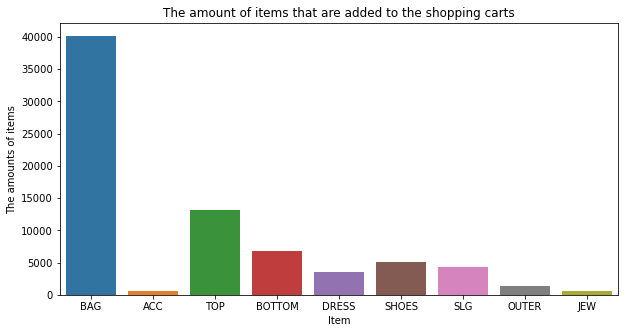

In [26]:
plt.figure(figsize = (10, 5))
sns.countplot(x = 'Item', data = data)

plt.ylabel('The amounts of items')
plt.title('The amount of items that are added to the shopping carts')

## ② brands

In [27]:
by_brands = data.groupby('Brand_no')

In [28]:
# count by brands
by_brands['Cart_amount'].count()

Brand_no
brand_1    41499
brand_2    26715
brand_3     7556
Name: Cart_amount, dtype: int64

Text(0.5, 1.0, 'The Counts by brands that are added to the shopping carts')

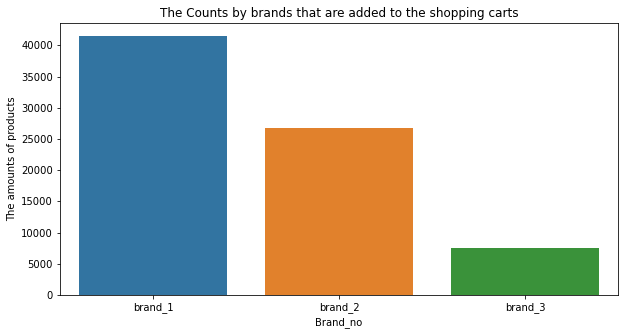

In [29]:
plt.figure(figsize = (10, 5))
sns.countplot(x = 'Brand_no', data = data)

plt.ylabel('The amounts of products')
plt.title('The Counts by brands that are added to the shopping carts')

## ③ Products

In [30]:
by_products = data.groupby('Product_no')

In [31]:
# count by brands
by_products_sorted = by_products['Product_no'].count().sort_values(ascending = False)
top10_products = by_products_sorted.head(10)

In [32]:
top10_products

Product_no
5811327539    2427
5811327538    2228
5811327543    2205
5811327544    2003
5811327541    1487
5811327742    1046
5812127502    1043
5812327547     972
5812127541     942
5811327501     627
Name: Product_no, dtype: int64

Text(0.5, 1.0, 'The amount of top 10 products that are added to shopping cart')

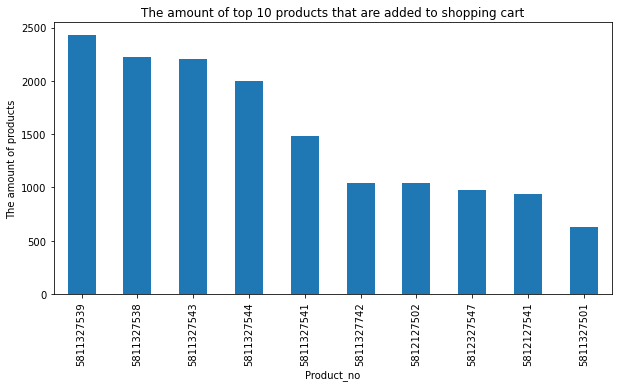

In [33]:
plt.figure(figsize = (10, 5))
top10_products.plot(kind = 'bar')

plt.ylabel('The amount of products')
plt.title('The amount of top 10 products that are added to shopping cart')

## ④ Price

### Full Price range of products in the cart

/Users/hayoung/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'The Full Price range of products in the cart')

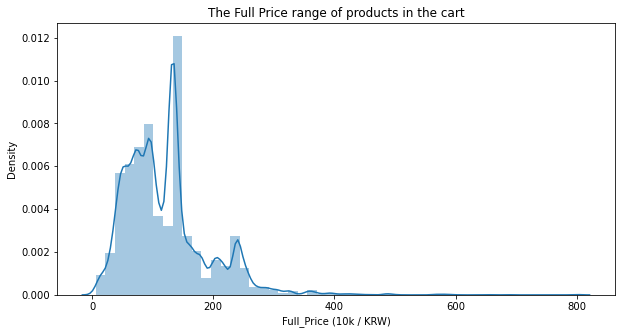

In [34]:
plt.figure(figsize = (10, 5))
sns.distplot(data['Full_Price (10k / KRW)'])

plt.title('The Full Price range of products in the cart')

### Min, max, average of full price
### - It ranges from 60k (KRW) to 7990k (KRW), with average 1210k (KRW)


In [35]:
data['Full_Price (10k / KRW)'].describe()

count    75770.000000
mean       121.373578
std         69.785708
min          6.000000
25%         75.000000
50%        109.000000
75%        143.000000
max        799.000000
Name: Full_Price (10k / KRW), dtype: float64


## 2. Through which funnels customers landed to add products in shopping cart?

In [36]:
data['Funnel'].value_counts()

failed to track    25731
category           23214
event              13876
Search              9613
site_main           1982
etc                 1163
live_shopping        191
Name: Funnel, dtype: int64

Text(0.5, 1.0, 'Sales/marketing funnels that customers went through right before the shopping cart')

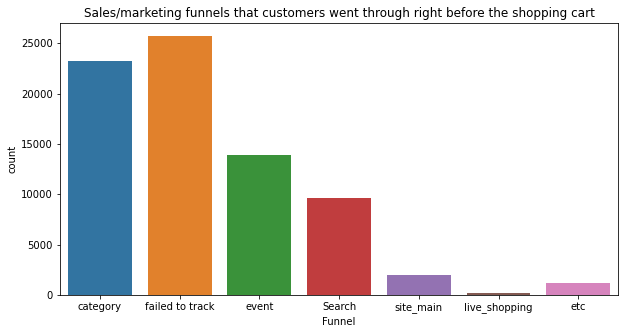

In [37]:
plt.figure(figsize = (10,5))

sns.countplot(x = 'Funnel', data = data)

plt.title('Sales/marketing funnels that customers went through right before the shopping cart')

# 3. The Conversion status by each factor : what are buying factors?

## The overall conversion rate turns out to be 5.4%

In [38]:
data['Purchase_date'][data['Purchase_date'] != 'not purchase'].count() / data['Cart_date'].count() * 100

5.421670845981259

## Conversion rate by relevant factors 

## ① Items
### - Jewelry had the highest rate (over 12%) and the bag had the lowest (under 4%)

In [39]:
#extract only relevant columns
sold_by_items= data[['Item','sold']]
sold_by_items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75770 entries, 0 to 75769
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Item    75770 non-null  object
 1   sold    75770 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1.2+ MB


In [40]:
# calculuate conversion rate by items
conversion = sold_by_items.groupby('Item').sum()
total = sold_by_items.groupby('Item').count()
conversion_rate = conversion / total *100

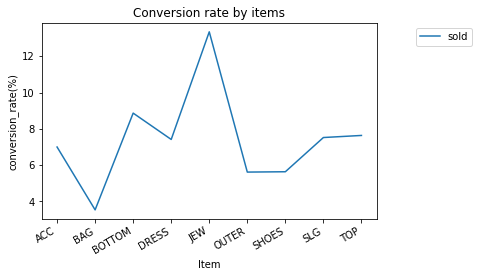

In [41]:
conversion_rate.plot(kind = 'line')
plt.gcf().autofmt_xdate()

plt.ylabel('conversion_rate(%)')
plt.title('Conversion rate by items')
plt.legend('conversion_rate(%)')
plt.legend(bbox_to_anchor=(1.3, 1))

## ② Brands
### - brand_3 had the highest rate (over 7%), brand_2 the similarly high (beneath 7%), and brand_1 the lowest rate (around 4%)

In [42]:
#extract only relevant columns
sold_by_brands= data[['Brand_no','sold']]

conversion_b = sold_by_brands.groupby('Brand_no').sum()
total_b = sold_by_brands.groupby('Brand_no').count()
conversion_rate_b = conversion_b / total_b *100

<Figure size 720x360 with 0 Axes>

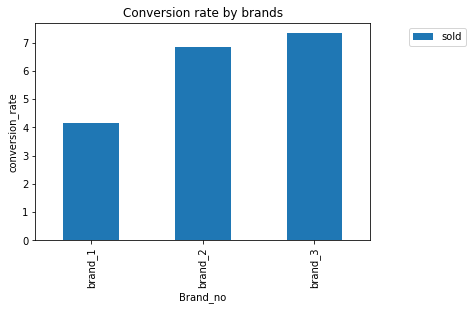

In [43]:
plt.figure(figsize = (10, 5))
conversion_rate_b.plot(kind = 'bar')

plt.ylabel('conversion_rate')
plt.title('Conversion rate by brands')
plt.legend('conversion_rate(%)')
plt.legend(bbox_to_anchor=(1.3, 1))

## ③ Funnels
### - 'Search' was the most effective channel when it comes to conversion, and 'event' was the second best (excluding 'failed to track'), where it seems that people 'search' products with some level of intention to purchase and that 'sales event' definitely has some effects to drive potential purchasing desire. 

In [44]:
#extract only relevant columns
sold_by_funnels= data[['Funnel','sold']]

conversion_f = sold_by_funnels.groupby('Funnel').sum()
total_f = sold_by_funnels.groupby('Funnel').count()
conversion_rate_f = conversion_f / total_f *100

<Figure size 720x504 with 0 Axes>

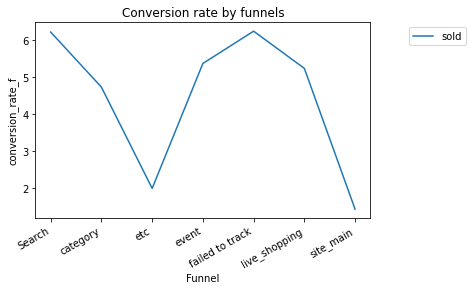

In [45]:
plt.figure(figsize = (10, 7))
conversion_rate_f.plot(kind = 'line')
plt.gcf().autofmt_xdate()

plt.ylabel('conversion_rate_f')
plt.title('Conversion rate by funnels')
plt.legend('conversion_rate(%)')
plt.legend(bbox_to_anchor=(1.3, 1))

## ④ Price and Promotion

## ● Full price range of purchased VS unpurchased products
### - Full prices of purchased ones are distributed in a little bit lower price range compared to unpurchased ones.

/Users/hayoung/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/hayoung/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2056: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)
/Users/hayoung/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarni

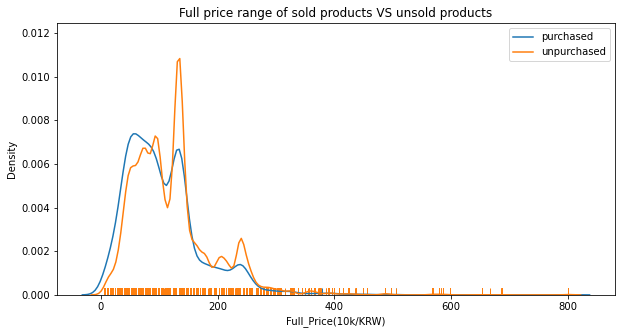

In [46]:
purchased_fullprice = data.loc[data['sold'] == 1]
unpurchased_fullprice = data.loc[data['sold'] == 0]

plt.figure(figsize = (10,5))
sns.distplot(purchased_fullprice[['Full_Price (10k / KRW)']], hist=False, rug = True)
sns.distplot(unpurchased_fullprice[['Full_Price (10k / KRW)']], hist=False, rug = True)

plt.xlabel('Full_Price(10k/KRW)')
plt.title('Full price range of sold products VS unsold products')
plt.legend(labels = ['purchased','unpurchased'],loc = 'upper right')

## ● Discount percentage distribution of purchased VS unpurchased products
### -The range of discount percentage of purchased products lies between 0% to 97%, the average is around 45% and the mode is 40%.
### -The range of discount percentage of unpurchased products lies between 0% to 80%, the average is around 31% and the mode is 0%.


/Users/hayoung/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/hayoung/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2056: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)
/Users/hayoung/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarni

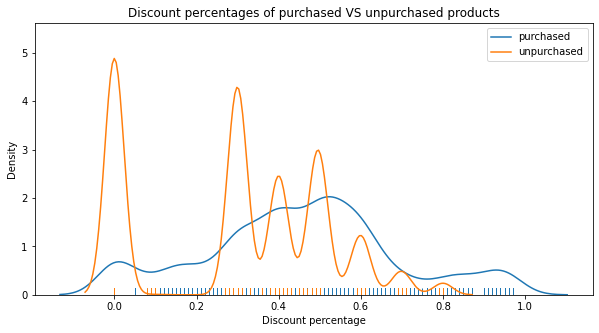

In [47]:
purchased_discountpercent = data.loc[data['sold'] == 1]
unpurchased_discountpercent = data.loc[data['sold'] == 0]

plt.figure(figsize = (10,5))
sns.distplot(purchased_discountpercent[['Discount_percent']], hist=False, rug = True)
sns.distplot(unpurchased_discountpercent[['Discount_percent']], hist=False, rug = True)

plt.xlabel('Discount percentage')
plt.title('Discount percentages of purchased VS unpurchased products')
plt.legend(labels = ['purchased','unpurchased'],loc = 'upper right')

In [48]:
purchased_discountpercent['Discount_percent'].describe()

count    4108.000000
mean        0.451273
std         0.233367
min         0.000000
25%         0.300000
50%         0.460000
75%         0.590000
max         0.970000
Name: Discount_percent, dtype: float64

In [49]:
purchased_discountpercent['Discount_percent'].mode()

0    0.4
dtype: float64

In [50]:
unpurchased_discountpercent['Discount_percent'].describe()

count    71662.000000
mean         0.303878
std          0.222597
min          0.000000
25%          0.000000
50%          0.300000
75%          0.490000
max          0.800000
Name: Discount_percent, dtype: float64

In [51]:
unpurchased_discountpercent['Discount_percent'].mode()

0    0.0
dtype: float64

## ● Discounted price distribution of purchased VS unpurchased products
### -The range of discounted price of purchased products lies between 10k(KRW) to 4400k(KRW), the average is around 550k(KRW) and the mode is 930k(KRW)
### -The range of discounted price of unpurchased products lies between 40k(KRW) to 8410k(KRW), the average is around 800k(KRW) and the mode is 930k(KRW)
### - The gap between the purchased and unpurchased products is higher in discounted price distribution than in full price distribution.

/Users/hayoung/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/hayoung/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2056: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)
/Users/hayoung/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarni

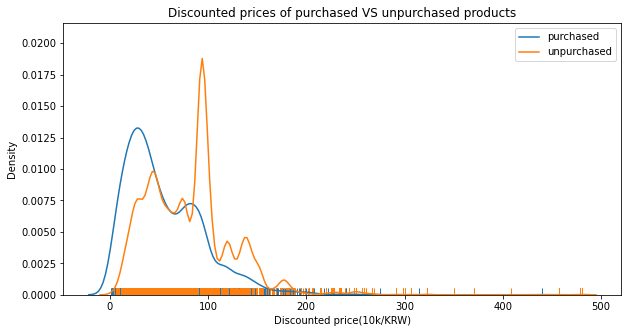

In [52]:
purchased_discountprice = data.loc[data['sold'] == 1]
unpurchased_discountprice = data.loc[data['sold'] == 0]

plt.figure(figsize = (10,5))
sns.distplot(purchased_discountprice[['Discounted_Price']], hist=False, rug = True)
sns.distplot(unpurchased_discountprice[['Discounted_Price']], hist=False, rug = True)

plt.xlabel('Discounted price(10k/KRW)')
plt.title('Discounted prices of purchased VS unpurchased products')
plt.legend(labels = ['purchased','unpurchased'],loc = 'upper right')

In [53]:
purchased_discountprice['Discounted_Price'].describe()

count    4108.000000
mean       55.425268
std        39.496866
min         1.000000
25%        25.000000
50%        45.000000
75%        80.000000
max       440.000000
Name: Discounted_Price, dtype: float64

In [54]:
purchased_discountprice['Discounted_Price'].mode()

0    93
dtype: int64

In [55]:
unpurchased_discountprice['Discounted_Price'].describe()

count    71662.000000
mean        80.448801
std         43.223443
min          4.000000
25%         46.000000
50%         79.000000
75%         98.000000
max        481.000000
Name: Discounted_Price, dtype: float64

In [56]:
unpurchased_discountprice['Discounted_Price'].mode()

0    93
dtype: int64

## ⑤ Coupon usage : Yes or No
### - Among the purchased orders, the number of 'coupon usage = Y' was higher than 'N'

In [57]:
data['Coupon_Y/N'].value_counts()

not purchase    71662
Y                1875
N                1684
Refund            549
Name: Coupon_Y/N, dtype: int64

<AxesSubplot:xlabel='Coupon_Y/N', ylabel='count'>

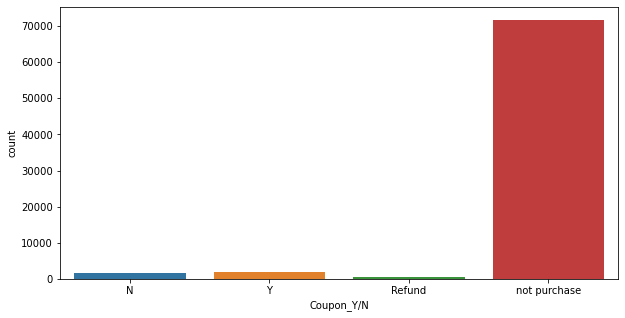

In [58]:
plt.figure(figsize = (10,5))

sns.countplot(x = 'Coupon_Y/N', data = data)

<AxesSubplot:xlabel='Coupon_Y/N', ylabel='count'>

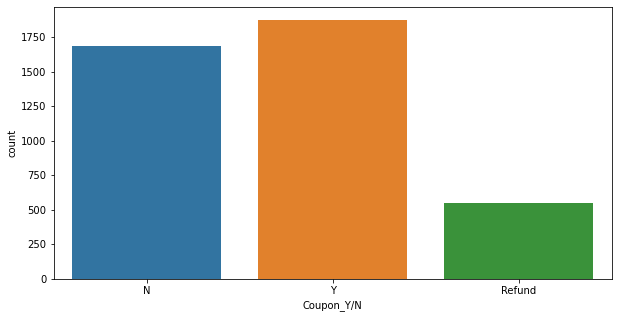

In [59]:
#narrowing down to the purchased orders
purchased_order = data[data['sold'] == 1]

plt.figure(figsize = (10,5))
sns.countplot(x = 'Coupon_Y/N', data = purchased_order)

## ⑥ Day diferences between 'Adding to the cart' and 'Purchasing'
### - The average gap between the two dates is around 4 days and the maximum is 118 days
### - The mode is 0 day which takes about 53% share among whole purchased orders
### - Rerferring to that '6 days' lies on 75 percentile, it seems that most people tend to purchase within short days after they add products to the cart / or people put products into the cart right before they purchase (53%) or with quite high level of purchase desire.

Text(0.5, 1.0, 'Day differences between the purchase_date and carried_in cart_date')

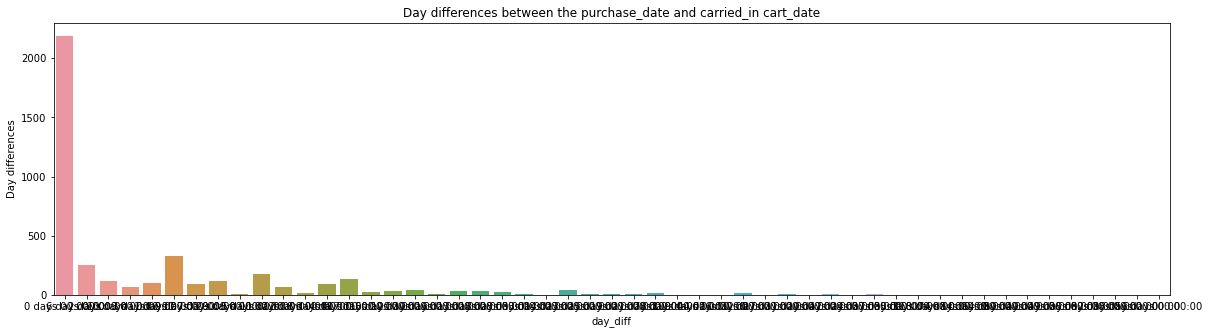

In [60]:
# in order to visualize by 'time_diff' as x-axis
plt.figure(figsize = (20, 5))
day_diff_graph = data[data['day_diff'] != 'not purchase']
sns.countplot(x = 'day_diff', data = day_diff_graph)

plt.ylabel('Day differences')
plt.title('Day differences between the purchase_date and carried_in cart_date')

In [61]:
day_diff_graph[day_diff_graph['day_diff'] == 0]['day_diff'].count() / day_diff_graph['day_diff'].count()

0.0

In [62]:
day_diff_graph['day_diff'].describe()

count                4108
unique                 51
top       0 days 00:00:00
freq                 2188
Name: day_diff, dtype: object

In [63]:
day_diff_graph['day_diff'].mode()

0   0 days
dtype: timedelta64[ns]

# Setting up the Data
## :Get ready to build the "Random Forest Classification Model"

## Categorical Features
#### Streamline the datasets by only leaving the relevant factors for conversion prediction

In [64]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75770 entries, 0 to 75769
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Shopping_cart_no        75770 non-null  int64         
 1   Membership_no           75768 non-null  float64       
 2   Cart_date               75770 non-null  datetime64[ns]
 3   Brand_no                75770 non-null  object        
 4   Product_sku_no          75770 non-null  object        
 5   Product_no              75770 non-null  object        
 6   Purchase_date           75770 non-null  object        
 7   Order_no                75770 non-null  object        
 8   Cart_amount             75770 non-null  int64         
 9   Purchase_amount         75770 non-null  object        
 10  Order_payment_amount    75770 non-null  object        
 11  Final_payment_amount    75770 non-null  object        
 12  Funnel                  75770 non-null  object

In [65]:
data_ml = data[['Funnel','Item', 'Brand_no', 'Full_Price (10k / KRW)','Discount_percent','Discounted_Price','sold']]

In [66]:
data_ml

,Funnel,Item,Brand_no,Full_Price (10k / KRW),Discount_percent,Discounted_Price,sold
0,category,BAG,brand_1,133,0.30,93,1
1,failed to track,BAG,brand_1,133,0.36,85,1
2,event,BAG,brand_1,137,0.46,74,1
3,failed to track,BAG,brand_1,133,0.53,63,1
4,failed to track,BAG,brand_1,133,0.95,85,1
...,...,...,...,...,...,...,...
75765,failed to track,BAG,brand_1,133,0.30,93,0
75766,category,TOP,brand_3,209,0.40,125,0
75767,category,BAG,brand_1,133,0.30,93,0
75768,site_main,TOP,brand_2,95,0.40,57,0


#### Convert categorical variables to dummie variables.

In [67]:
data_ml_fn = pd.get_dummies(data_ml, columns=['Funnel', 'Item', 'Brand_no'], drop_first=True)

In [68]:
data_ml_fn

,Full_Price (10k / KRW),Discount_percent,Discounted_Price,sold,Funnel_category,Funnel_etc,Funnel_event,Funnel_failed to track,Funnel_live_shopping,Funnel_site_main,Item_BAG,Item_BOTTOM,Item_DRESS,Item_JEW,Item_OUTER,Item_SHOES,Item_SLG,Item_TOP,Brand_no_brand_2,Brand_no_brand_3
0,133,0.30,93,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
1,133,0.36,85,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0
2,137,0.46,74,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0
3,133,0.53,63,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0
4,133,0.95,85,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75765,133,0.30,93,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0
75766,209,0.40,125,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1
75767,133,0.30,93,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
75768,95,0.40,57,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0


### Train Test Split

In [69]:
from sklearn.model_selection import train_test_split

In [70]:
X = data_ml_fn.drop('sold',axis=1)
y = data_ml_fn['sold']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=101, stratify =y)

# Random Forest Model

## 1. Standard Random Forest (SRF)
### Build the model

In [71]:
from statistics import mean
from sklearn.model_selection import cross_validate
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import plot_confusion_matrix
from sklearn.ensemble import RandomForestClassifier

In [72]:
SRF = RandomForestClassifier(n_estimators=150, random_state=101)

### Train the model

In [73]:
SRF.fit(X_train, y_train)

RandomForestClassifier(n_estimators=150, random_state=101)

### Evaluate SRF model

In [74]:
#Create Stratified K-fold cross validation
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=101)
scoring = ('f1', 'recall', 'precision')

#Evaluate SRF model
scores = cross_validate(SRF, X, y, scoring=scoring, cv=cv)

#Get average evaluation metrics
print('Mean f1: %.3f' % mean(scores['test_f1']))
print('Mean recall: %.3f' % mean(scores['test_recall']))
print('Mean precision: %.3f' % mean(scores['test_precision']))

Mean f1: 0.760
Mean recall: 0.620
Mean precision: 0.984


In [75]:
recall_score_SRF = 0.620
precision_score_SRF = 0.984

### Prediction and Evaluation

In [76]:
y_pred = SRF.predict(X_test)

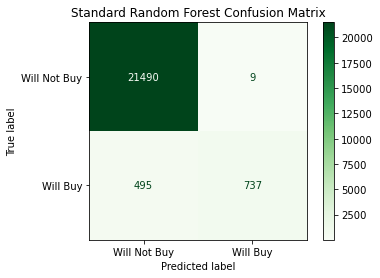

In [77]:
#Create confusion matrix
fig = plot_confusion_matrix(SRF, X_test, y_test, display_labels=['Will Not Buy', 'Will Buy'], cmap='Greens')
plt.title('Standard Random Forest Confusion Matrix')
plt.show()

## As the class imbalance is strong (sold: unsold = 1:19), complementing Random Forest Classifier with stratified sampling techniques seems needed.





## 2. Balanced Random Forest (BRF)

### Build the model

In [78]:
from imblearn.ensemble import BalancedRandomForestClassifier
BRFC = BalancedRandomForestClassifier(n_estimators=150, random_state=103)

### Train the model

In [79]:
BRFC.fit(X_train, y_train)

BalancedRandomForestClassifier(n_estimators=150, random_state=103)

### Evaluate BRFC model

In [80]:
#Create Stratified K-fold cross validation
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=102)
scoring = ('f1', 'recall', 'precision')

#Evaluate BRFC model
scores = cross_validate(BRFC, X, y, scoring=scoring, cv=cv)

#Get average evaluation metrics
print('Mean f1: %.3f' % mean(scores['test_f1']))
print('Mean recall: %.3f' % mean(scores['test_recall']))
print('Mean precision: %.3f' % mean(scores['test_precision']))

Mean f1: 0.469
Mean recall: 0.770
Mean precision: 0.337


In [81]:
recall_score_BRFC = 0.770
precision_score_BRFC = 0.337

### Prediction and Evaluation

In [82]:
y_pred2 = BRFC.predict(X_test)

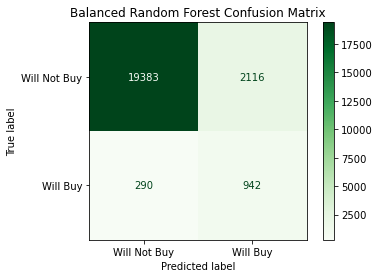

In [83]:
#Create confusion matrix
fig = plot_confusion_matrix(BRFC, X_test, y_test, display_labels=['Will Not Buy', 'Will Buy'], cmap='Greens')
plt.title('Balanced Random Forest Confusion Matrix')
plt.show()

## 3. SMOTE (Synthetic Minority Oversampling Technique) using Standard Random Forest

### Build the model

In [84]:
from imblearn.over_sampling import SMOTE

#Use SMOTE to oversample the minority class
oversample = SMOTE()
over_X, over_y = oversample.fit_resample(X, y)
over_X_train, over_X_test, over_y_train, over_y_test = train_test_split(over_X, over_y, test_size=0.3, stratify=over_y)

#Build SMOTE SRF model
SMOTE_SRF = RandomForestClassifier(n_estimators=150, random_state=101)

### Train the model

In [85]:
SMOTE_SRF.fit(over_X_train, over_y_train)

RandomForestClassifier(n_estimators=150, random_state=101)

### Evaluate SMOTE model 

In [86]:
#Create Stratified K-fold cross validation
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=102)
scoring = ('f1', 'recall', 'precision')

#Evaluate SMOTE SRF model
scores = cross_validate(SMOTE_SRF, over_X, over_y, scoring=scoring, cv=cv)

#Get average evaluation metrics
print('Mean f1: %.3f' % mean(scores['test_f1']))
print('Mean recall: %.3f' % mean(scores['test_recall']))
print('Mean precision: %.3f' % mean(scores['test_precision']))

Mean f1: 0.936
Mean recall: 0.903
Mean precision: 0.971


In [88]:
recall_score_SMOTE = 0.903
precision_score_SMOTE = 0.971

### Prediction and Evaluation

In [89]:
y_pred3 = SMOTE_SRF.predict(X_test)

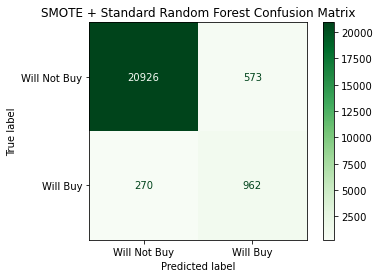

In [90]:
#Create confusion matrix
fig = plot_confusion_matrix(SMOTE_SRF, X_test, y_test, display_labels=['Will Not Buy', 'Will Buy'], cmap='Greens')
plt.title('SMOTE + Standard Random Forest Confusion Matrix')
plt.show()

## 4. Precision-recall curve
### Make a direct comparison between above three models that use the same imbalanced data 

Text(0.5, 1.0, 'Precision-Recall curve')

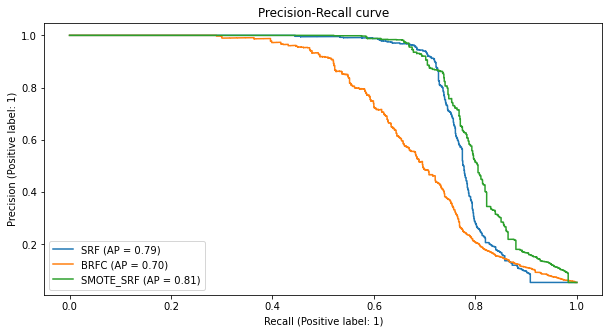

In [91]:
from sklearn.metrics import plot_precision_recall_curve
from sklearn.metrics import precision_recall_curve

plt.figure(figsize = (10,5))
plot_precision_recall_curve(SRF, X_test, y_test, ax = plt.gca(), name = 'SRF')
plot_precision_recall_curve(BRFC, X_test, y_test, ax = plt.gca(), name = 'BRFC')
plot_precision_recall_curve(SMOTE_SRF, X_test, y_test, ax = plt.gca(), name = 'SMOTE_SRF');

plt.title('Precision-Recall curve')

## The Precision-recall curves indicate that SMOTE using SRF has the best performance overally and SRF is the second best, showing a lot of overlap with SMOTE_SRF. 

# Lastly, check the impacts of each factor
### - The promoiton and the price turned out to be the most influencing factors when it comes to the conversion. Specifically, the 'Discount percent' impacts with almost half of the power, and then the actual prices (discounted, full) come next. Aside from that, brand_3 and the bag items had a comparatively higher impact to the conversion than the rest of other factors.

In [92]:
SRF.feature_importances_

array([1.67082150e-01, 4.67342337e-01, 2.69941974e-01, 5.59195159e-03,
       1.17562552e-03, 5.14797540e-03, 6.10284552e-03, 3.92738560e-04,
       1.68197907e-03, 1.11722665e-02, 5.23010848e-03, 4.05807005e-03,
       2.77772443e-03, 1.74933774e-03, 4.11166980e-03, 7.78489814e-03,
       5.47270620e-03, 1.39543691e-02, 1.92292733e-02])

In [93]:
X_train.columns

Index(['Full_Price (10k / KRW)', 'Discount_percent', 'Discounted_Price',
       'Funnel_category', 'Funnel_etc', 'Funnel_event',
       'Funnel_failed to track', 'Funnel_live_shopping', 'Funnel_site_main',
       'Item_BAG', 'Item_BOTTOM', 'Item_DRESS', 'Item_JEW', 'Item_OUTER',
       'Item_SHOES', 'Item_SLG', 'Item_TOP', 'Brand_no_brand_2',
       'Brand_no_brand_3'],
      dtype='object')

<AxesSubplot:>

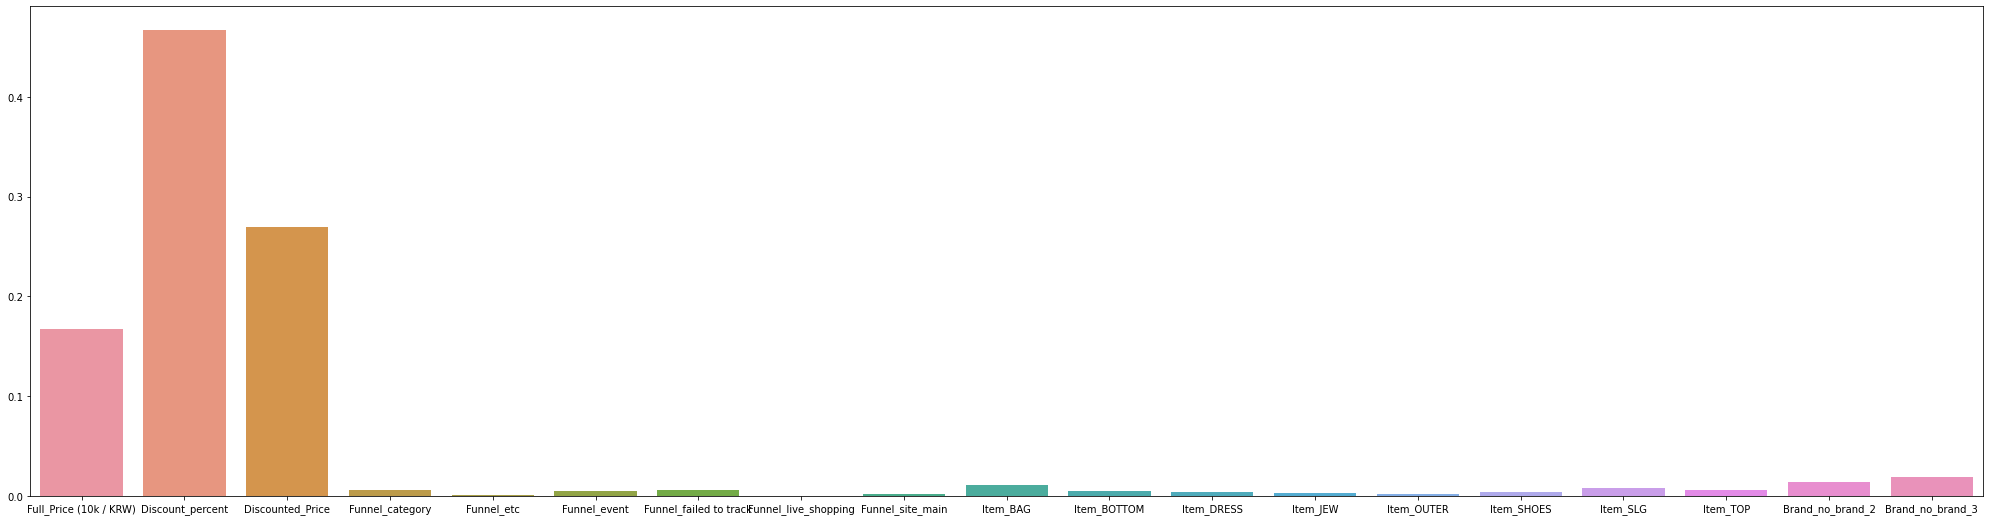

In [94]:
plt.figure(figsize=(35,10))
plt.gcf().autofmt_xdate()

sns.barplot(x = X_train.columns, y = SRF.feature_importances_)

## Finding : 
### - Under this data settings, it seems that the discount promotion is effective in driving a purchase conversion. The average discount percent that moved customers to purchase was about 45%, and in the actual price wise was around 550k(KRW). 

### - Among the Random Forest models, SMOTE using Standard Random Forest turned out to show the best performance in deciding whether the customers would purchase their products in the shopping carts or not, showing the overall highest Precision and recall scores.